# deepBreaks applications
## Predicting the niche of the haemophilus parainfluenzae based on its genome sequence   
In this study we are trying to use 1006 nucleotide sequences to train predictive models for predicting a niches of Haemophilus parainfluenzae which in this study are tongue dorsum, buccal mucosa, and supragingival plaque.  
After that, we use the top 3 models to study their feature importances and merge their results. We cover all three steps of preprocessing, modelling, and interpretaion of the models. Finally we vizualize the results of the models and prioritize the most imposrtant sites of the sequences.

<img src="../img/hmp/fig1.png" alt="Drawing" style="width: 400px;"/>

In [1]:
# importing deepBreaks libraries 
from deepBreaks import preprocessing as prp
from deepBreaks import visualization as viz
from deepBreaks import models as ml
import os
import datetime
import warnings

In [2]:
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [3]:
# defining user params, file pathes, analysis type

# path to sequences
seqFileName = '/Users/mbagh/Documents/RahLab/deepBreaks_data/hmp/s__Haemophilus_parainfluenzae.tsv'

# path to metadata
metaDataFileName = '/Users/mbagh/Documents/RahLab/deepBreaks_data/hmp/my_HMP_metadata.tsv'

# name of the phenotype
mt = 'Body_site'

# type of the sequences
seq_type = 'nu'
# type of the analysis if it is a classification model, then we put cl instead of reg
anaType = 'cl'
sampleFrac=1

In [4]:
# making a unique directory for saving the reports of the analysis
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
seqFile = seqFileName.split('.')[0]
report_dir = str(seqFile +'_' + mt + '_' + dt_label)
os.makedirs(report_dir)

direcory preparation


In [5]:
%%time
print('reading meta-data')
# importing metadata
metaData = prp.read_data(metaDataFileName, seq_type = None, is_main=False)
print('metaData:', metaData.shape)

# importing sequences data
print('reading fasta file')
df = prp.read_data(seqFileName, seq_type = seq_type, is_main=True)

positions = df.shape[1]
print('Done')
print('Shape of data is: ', df.shape)

reading meta-data
metaData: (2355, 3)
reading fasta file
Done
Shape of data is:  (1111, 49839)
CPU times: user 1min 21s, sys: 3.65 s, total: 1min 25s
Wall time: 1min 26s


In [7]:
# selecting only the classes with enough number of samples
df = prp.balanced_classes(dat=df, meta_dat=metaData, feature=mt)

In [8]:
df.shape

(1006, 49839)

**Attention**: metadata and sequences data should have the names as their row names and for each sequence their must be a value in the meta data file.

In [9]:
print('metadata looks like this:')
metaData.head()

metadata looks like this:


,Body_area,Body_site,Gender
SRS011061,Gut,Stool,Female
SRS011084,Gut,Stool,Male
SRS011086,Oral,Tongue_dorsum,Female
SRS011090,Oral,Buccal_mucosa,Female
SRS011098,Oral,Supragingival_plaque,Female


In [10]:
print('sequence data looks like this:')
df.head()

sequence data looks like this:


,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,...,p49830,p49831,p49832,p49833,p49834,p49835,p49836,p49837,p49838,p49839
SRS011086,A,T,T,T,G,C,A,A,C,A,...,T,T,A,T,T,T,C,A,T,C
SRS011098,A,T,T,T,G,C,A,A,C,A,...,T,T,A,T,T,T,C,A,T,C
SRS011115,A,T,T,T,G,C,A,A,C,A,...,T,T,A,T,T,T,C,A,T,C
SRS011126,A,T,T,T,G,C,A,A,C,A,...,T,T,A,T,T,T,C,A,T,C
SRS011140,A,T,T,T,G,C,A,A,C,A,...,T,T,A,T,T,T,C,A,T,C


### Preprocessing
In this step, we do all these steps:
1. dropping columns with a number of missing values above a certain threshold  
2. dropping zero entropy columns  
3. imputing missing values with the mode of that column  
4. replacing cases with a frequency below a threshold (default 1.5%) with the mode of that column
5. dropping zero entropy columns
6. use statistical tests (each position against the phenotype) and drop columns with p-values below a threshold (default 0.25)
7. one-hot encode the remaining columns
8. calculate the pair-wise distance matrix for all of the columns
9. use the distance matrix for DBSCAN and cluster the correlated positions together
10. keep only one column (closes to center of each cluster) for each group and drop the rest from the training data set

In [11]:
%%time
# taking care of missing data
print('Shape of data before missing/constant care: ', df.shape)
df = prp.missing_constant_care(df)
print('Shape of data after missing/constant care: ', df.shape)

Shape of data before missing/constant care:  (1006, 49839)
Shape of data after missing/constant care:  (1006, 12208)
CPU times: user 29.9 s, sys: 1.07 s, total: 31 s
Wall time: 31 s


In [12]:
%%time
# taking care of ultra-rare cases
print('Shape of data before imbalanced care: ', df.shape)
df = prp.imb_care(dat=df, imbalance_threshold=0.025)
print('Shape of data after imbalanced care: ', df.shape)

Shape of data before imbalanced care:  (1006, 12208)
Shape of data after imbalanced care:  (1006, 5747)
CPU times: user 10.2 s, sys: 70.5 ms, total: 10.3 s
Wall time: 10.2 s


In [13]:
%%time
# you may want to perform your analysis only on a random sample of the positions.
# Here you can have a random sample of your main data set.
print('number of columns of main data befor: ', df.shape[1])
df = prp.col_sampler(dat=df, sample_frac=sampleFrac)
print('number of columns of main data after: ', df.shape[1])

number of columns of main data befor:  5747
number of columns of main data after:  5747
CPU times: user 524 µs, sys: 110 µs, total: 634 µs
Wall time: 611 µs


In [14]:
%%time
# Use statistical tests to drop redundant features.
print('number of columns of main data befor: ', df.shape[1])
df_cleaned = prp.redundant_drop(dat=df, meta_dat=metaData,
                        feature=mt, model_type=anaType,
                        threshold=0.25,
                        report_dir=report_dir)
print('number of columns of main data after: ', df_cleaned.shape[1])

number of columns of main data befor:  5747
number of columns of main data after:  5582
CPU times: user 17 s, sys: 112 ms, total: 17.1 s
Wall time: 17.1 s


In [15]:
%%time
print('one-hot encoding the dataset')
df_cleaned = prp.get_dummies(dat=df_cleaned, drop_first=True)

one-hot encoding the dataset
CPU times: user 1.74 s, sys: 17.5 ms, total: 1.76 s
Wall time: 1.76 s


In [16]:
%%time
print('calculating the distance matrix')
cr = prp.distance_calc(dat=df_cleaned,
                       dist_method='correlation',
                       report_dir=report_dir)
print(cr.shape)

calculating the distance matrix
(6269, 6269)
CPU times: user 1min, sys: 596 ms, total: 1min
Wall time: 1min


In [17]:
print('The distance matrix looks like this.\n The values are between 0 (exact the same) and 1 (non-related).')
cr.head()

The distance matrix looks like this.
 The values are between 0 (exact the same) and 1 (non-related).


,p1366_G,p1369_T,p1395_G,p1398_G,p1401_T,p1407_T,p1408_T,p1411_T,p1416_G,p1440_G,...,p49775_T,p49778_T,p49781_T,p49787_T,p49790_T,p49808_C,p49808_T,p49811_T,p49820_G,p49832_G
p1366_G,0.000000,0.916761,0.940834,0.952370,0.969279,0.970300,0.957532,0.939453,0.969279,0.943767,...,0.938681,0.965227,0.969279,0.953136,0.999454,0.954233,0.958430,0.923528,0.942754,0.995717
p1369_T,0.916761,0.000000,0.832023,0.885706,0.935074,0.885114,0.888821,0.306683,0.935074,0.861825,...,0.970981,0.933170,0.987428,0.961704,0.998611,0.777055,0.986665,0.776671,0.867952,0.963896
p1395_G,0.940834,0.832023,0.000000,0.998628,0.927315,0.703865,0.899522,0.865863,0.707743,0.804047,...,0.883869,0.972955,0.989744,0.911700,0.999783,0.907973,0.981460,0.870844,0.874093,0.846497
p1398_G,0.952370,0.885706,0.998628,0.000000,0.355019,0.923097,0.936382,0.922393,0.950710,0.806251,...,0.924774,0.978421,0.950710,0.962230,0.892514,0.923152,0.945684,0.989101,0.927941,0.925105
p1401_T,0.969279,0.935074,0.927315,0.355019,0.000000,0.950399,0.958967,0.961012,0.970317,0.971485,...,0.986987,0.961967,0.958670,0.978885,0.798256,0.999882,0.918331,0.908453,0.965100,0.907411


In [18]:
%%time
print('finding colinear groups')
dc_df = prp.db_grouped(dat = cr,
                       report_dir=report_dir,
                       threshold=.25,
                       needs_pivot=False)

finding colinear groups
CPU times: user 4.39 s, sys: 96.7 ms, total: 4.48 s
Wall time: 4.55 s


In [19]:
print('The result of the last step is a dataframe with two columns,\
1)feature and 2)group.\nif there are no groups, it will be an empty dataframe')
dc_df.head()

The result of the last step is a dataframe with two columns,1)feature and 2)group.
if there are no groups, it will be an empty dataframe


,feature,group
7,p1411_T,g0
10,p1443_T,g1
12,p1462_T,g0
15,p1477_G,g1
17,p1485_G,g1


Then, we pass the above calculated groupes into the *group_feature* function. This function finds the distance of all the group members to the center of the group (median). The result will be a dictionary of columns like this:  
\
{\
group1_representativ:[member1, member2,...],  
group2_representativ:[member1, member2,...],...  
}

In [20]:
%%time
print('grouping features')
dc = prp.group_features(dat=df_cleaned,
                        group_dat=dc_df,
                        report_dir=report_dir)

grouping features
CPU times: user 1.24 s, sys: 7.8 ms, total: 1.24 s
Wall time: 1.24 s


In [21]:
print('dropping correlated features')
print('Shape of data before collinearity care: ', df_cleaned.shape)
df_cleaned = prp.cor_remove(df_cleaned, dc)
print('Shape of data after collinearity care: ', df_cleaned.shape)

dropping correlated features
Shape of data before collinearity care:  (1006, 6269)
Shape of data after collinearity care:  (1006, 4572)


In [22]:
#merge with meta data
df = df.merge(metaData[mt], left_index=True, right_index=True)
df_cleaned = df_cleaned.merge(metaData[mt], left_index=True, right_index=True)

## Modelling
In this step, we try to fit multiple models to the training dataset and rank them based on their performance. By default, we select the top 3 three models for further analysis.  
During this step, deepBreaks creates a CSV file containing all the fitted models with their performance metrics. These metrics are based on an average of 10-fold cross-validation.

In [23]:
%%time
models_to_select = 3 # number of top models to select
top_models, train_cols, model_names = ml.fit_models(dat = df_cleaned,
                                                    meta_var=mt,
                                                    model_type=anaType, 
                                                    models_to_select=models_to_select,
                                                    report_dir=report_dir)

,Description,Value
0,session_id,123
1,Target,Body_site
2,Target Type,Multiclass
3,Label Encoded,"Buccal_mucosa: 0, Supragingival_plaque: 1, Tongue_dorsum: 2"
4,Original Data,"(1006, 4573)"
5,Missing Values,False
6,Numeric Features,4572
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


CPU times: user 1min 2s, sys: 13.9 s, total: 1min 16s
Wall time: 1min 58s


## Interpretation 
In this step, we use the training data set, positions, and the top models to report the most discriminative positions in the sequences associated with the phenotype.  
we report the feature importances for all top models separately and make a box plot (regression) or stacked bar plot (classification) for the top 4 positions.

/Users/mbagh/Documents/RahLab/deepBreaks_data/hmp/s__Haemophilus_parainfluenzae_Body_site_2022-10-18_13-02-50/Logistic Regression_350.png
Logistic Regression  Done
/Users/mbagh/Documents/RahLab/deepBreaks_data/hmp/s__Haemophilus_parainfluenzae_Body_site_2022-10-18_13-02-50/Extra Trees Classifier_350.png
Extra Trees Classifier  Done
/Users/mbagh/Documents/RahLab/deepBreaks_data/hmp/s__Haemophilus_parainfluenzae_Body_site_2022-10-18_13-02-50/Extreme Gradient Boosting_350.png
Extreme Gradient Boosting  Done


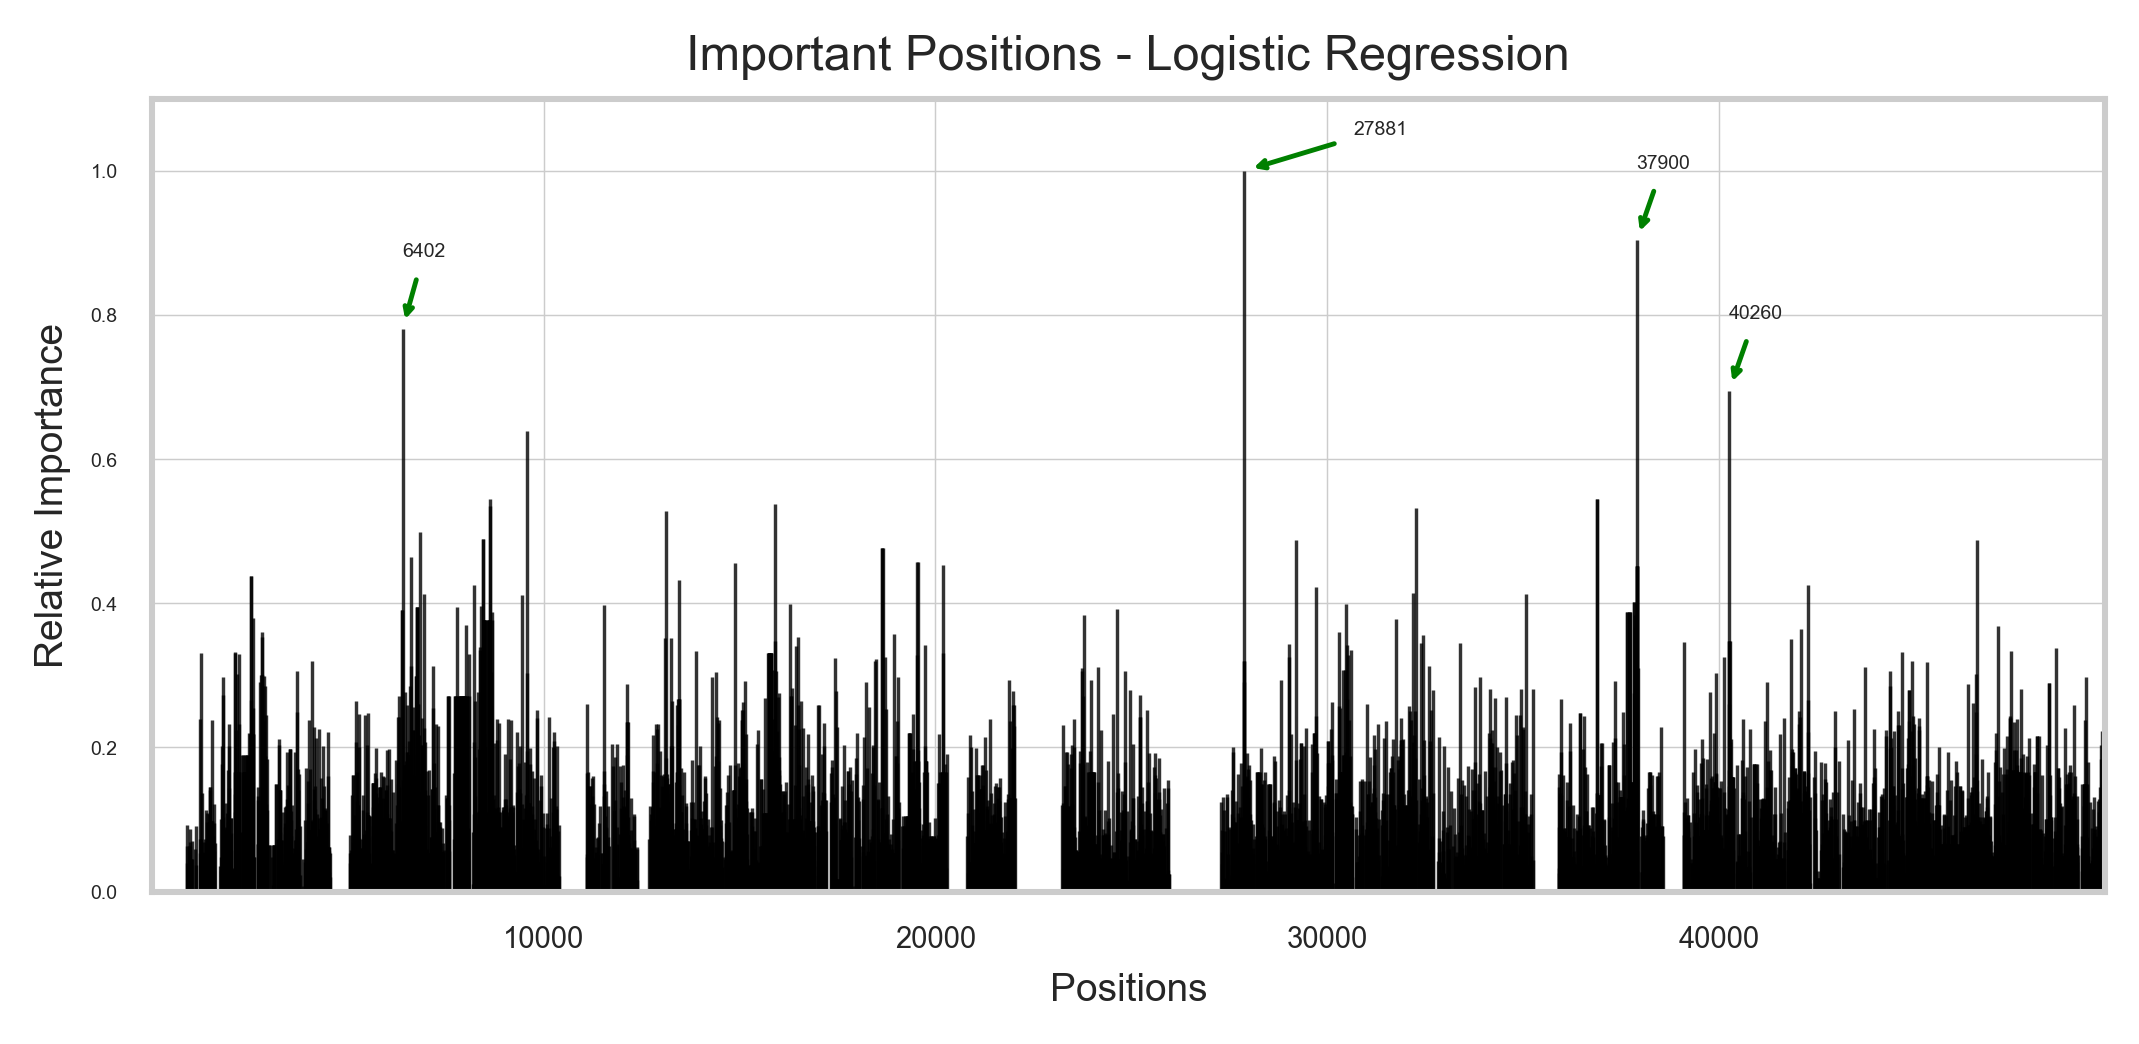

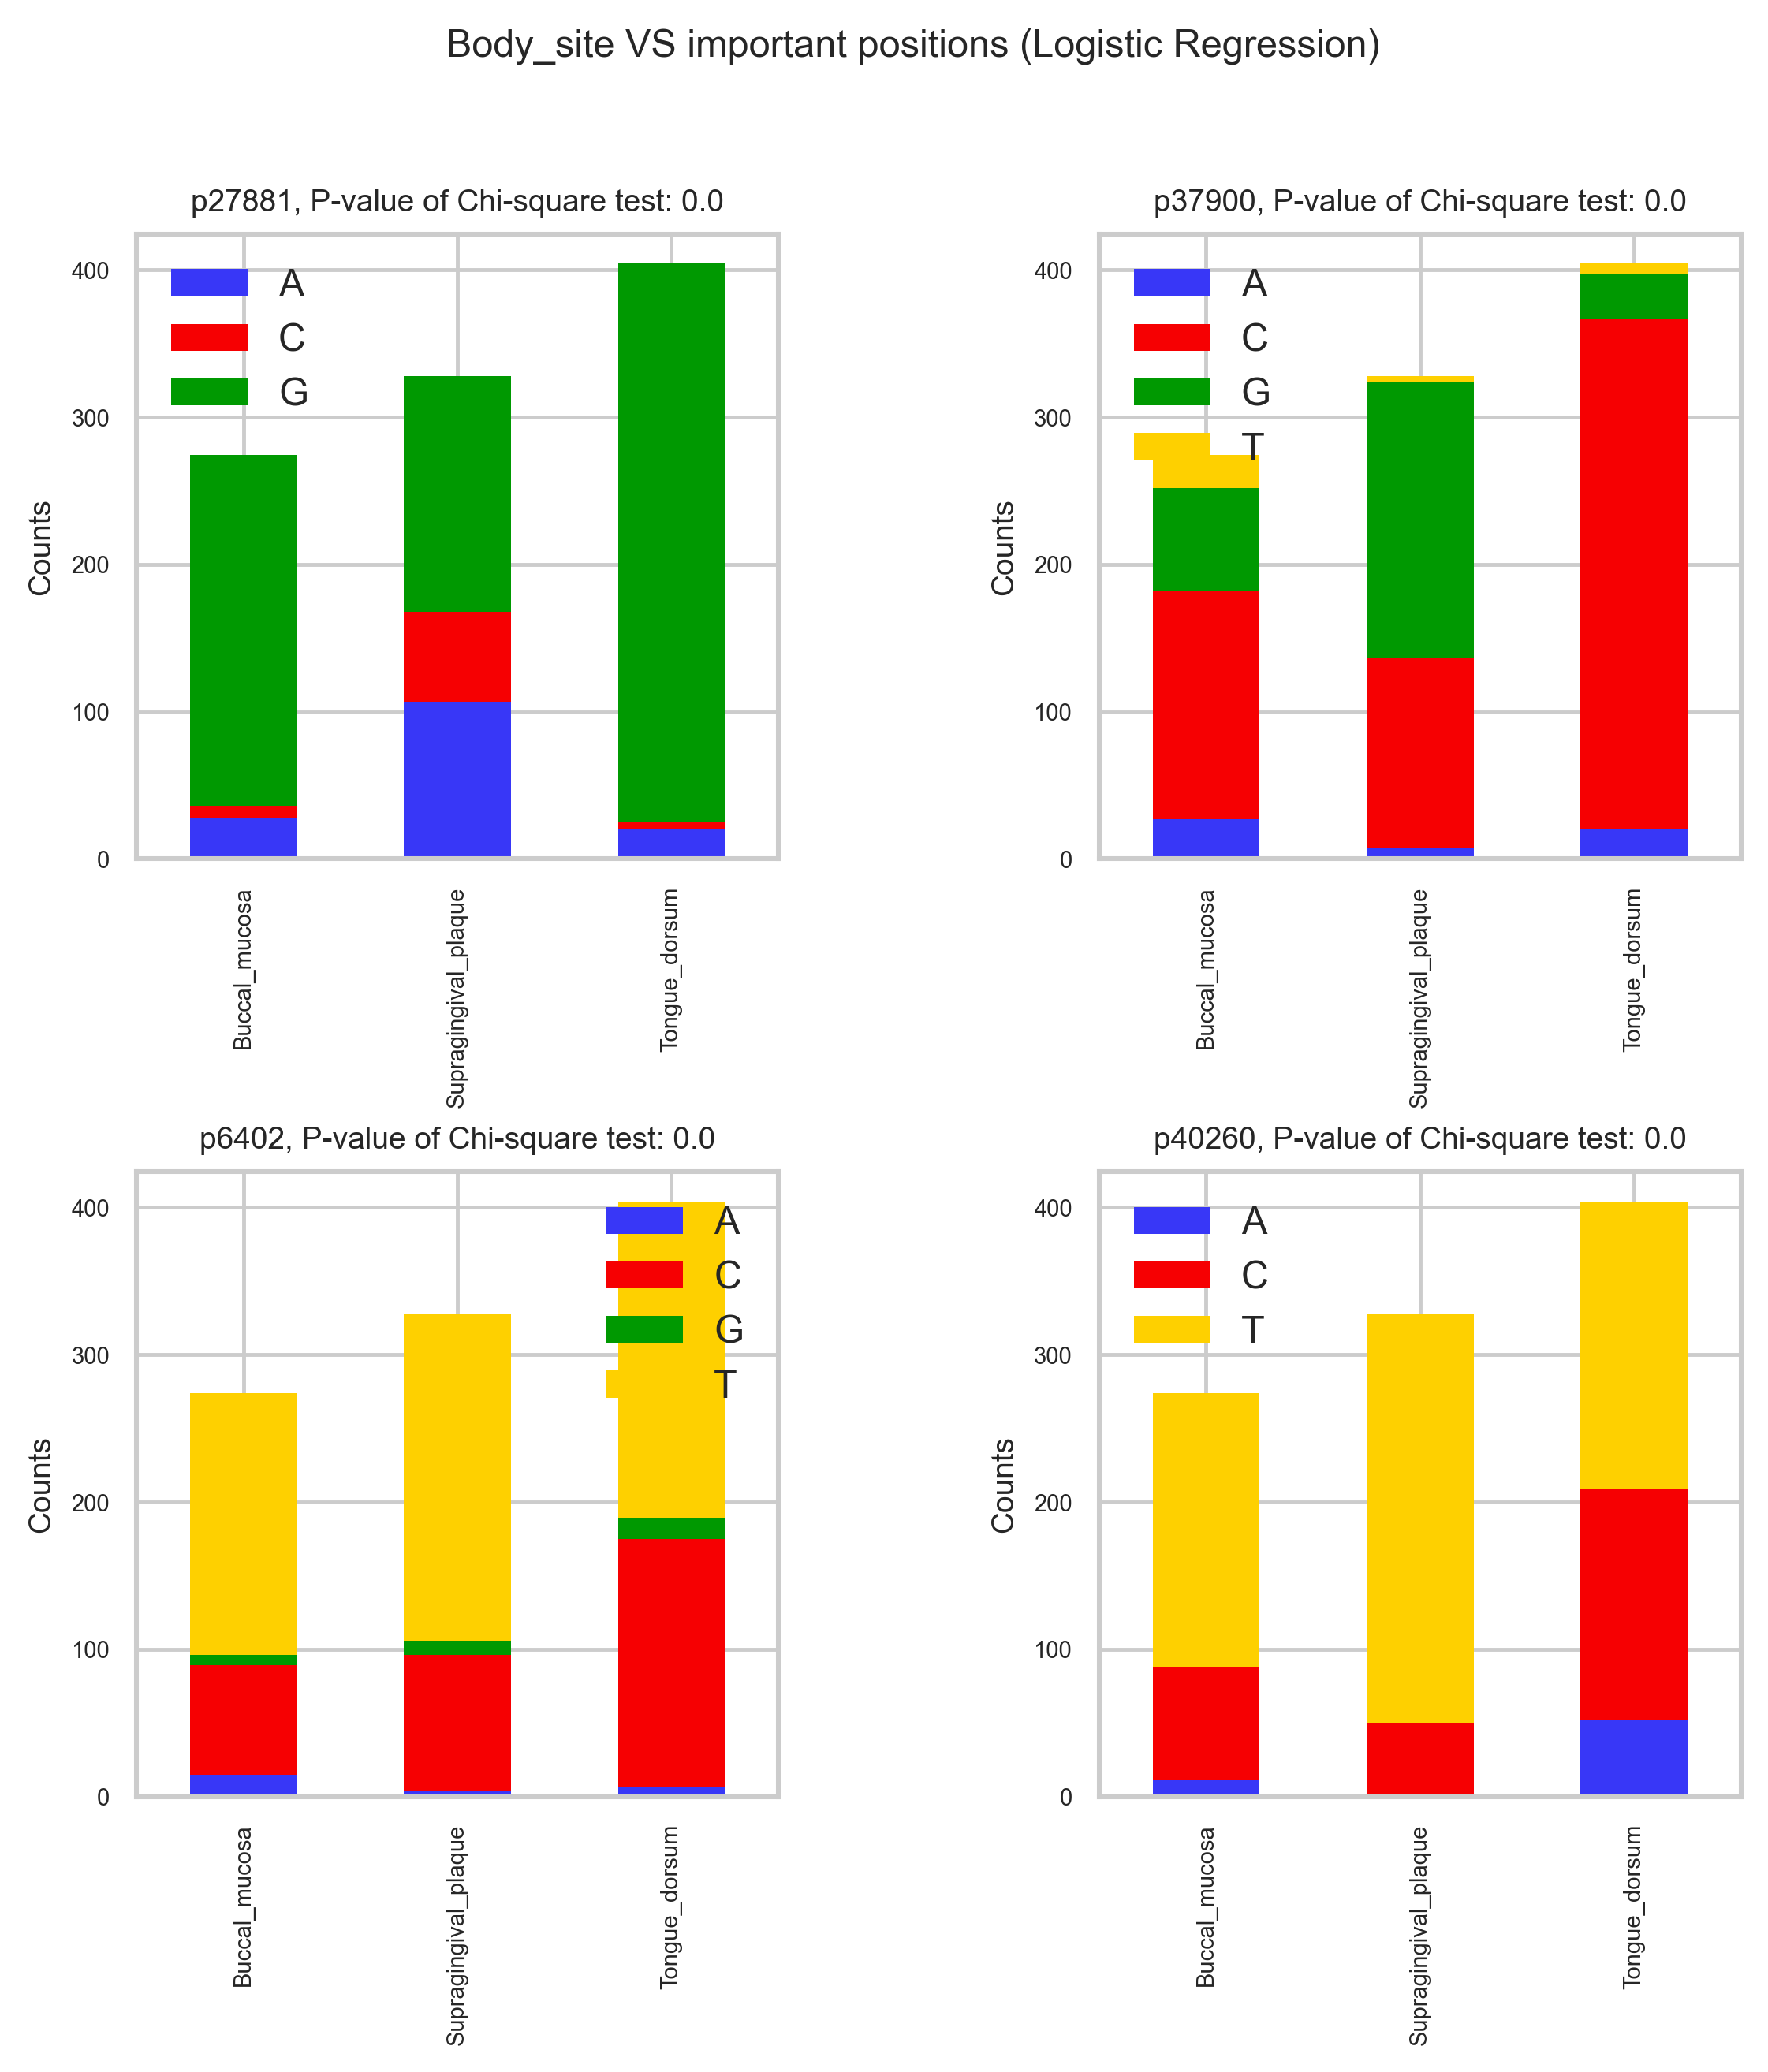

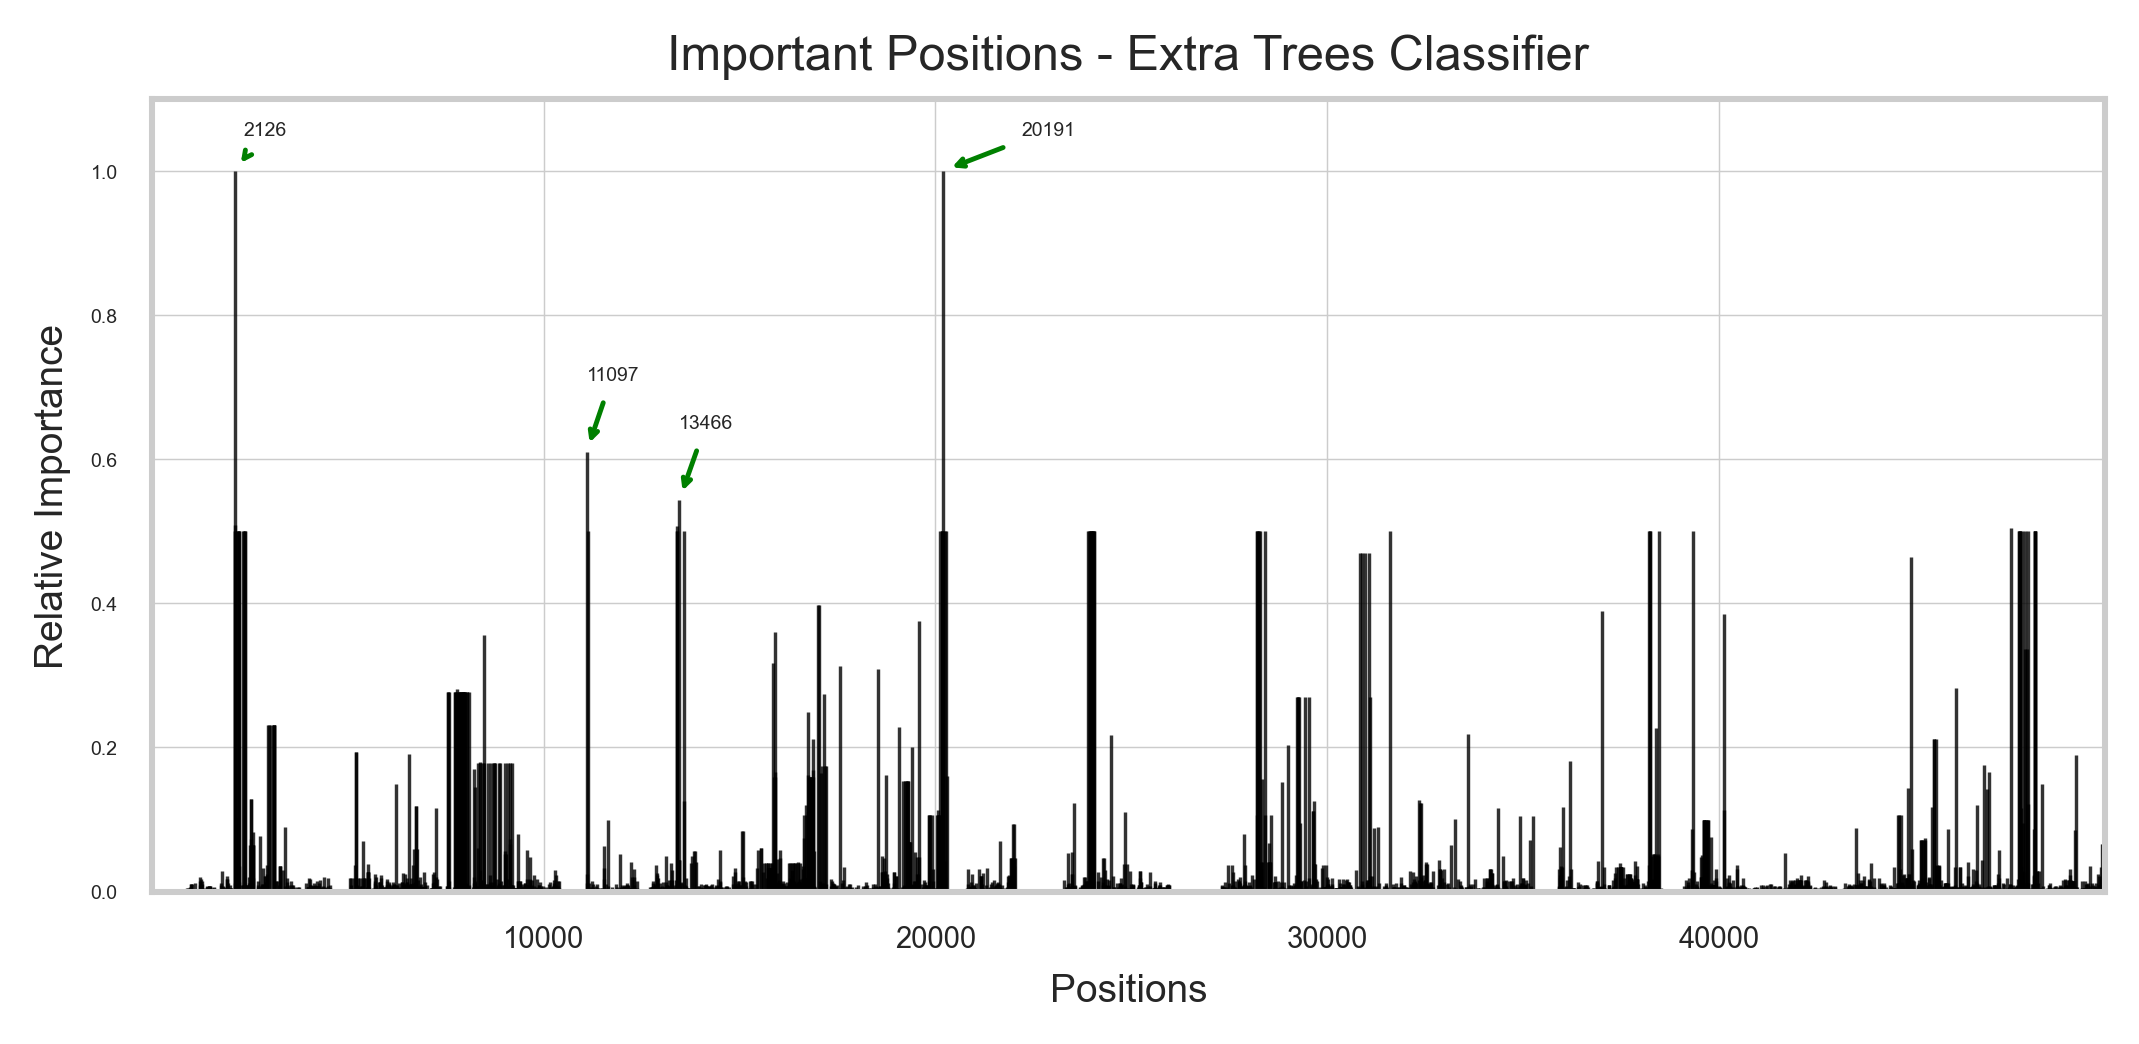

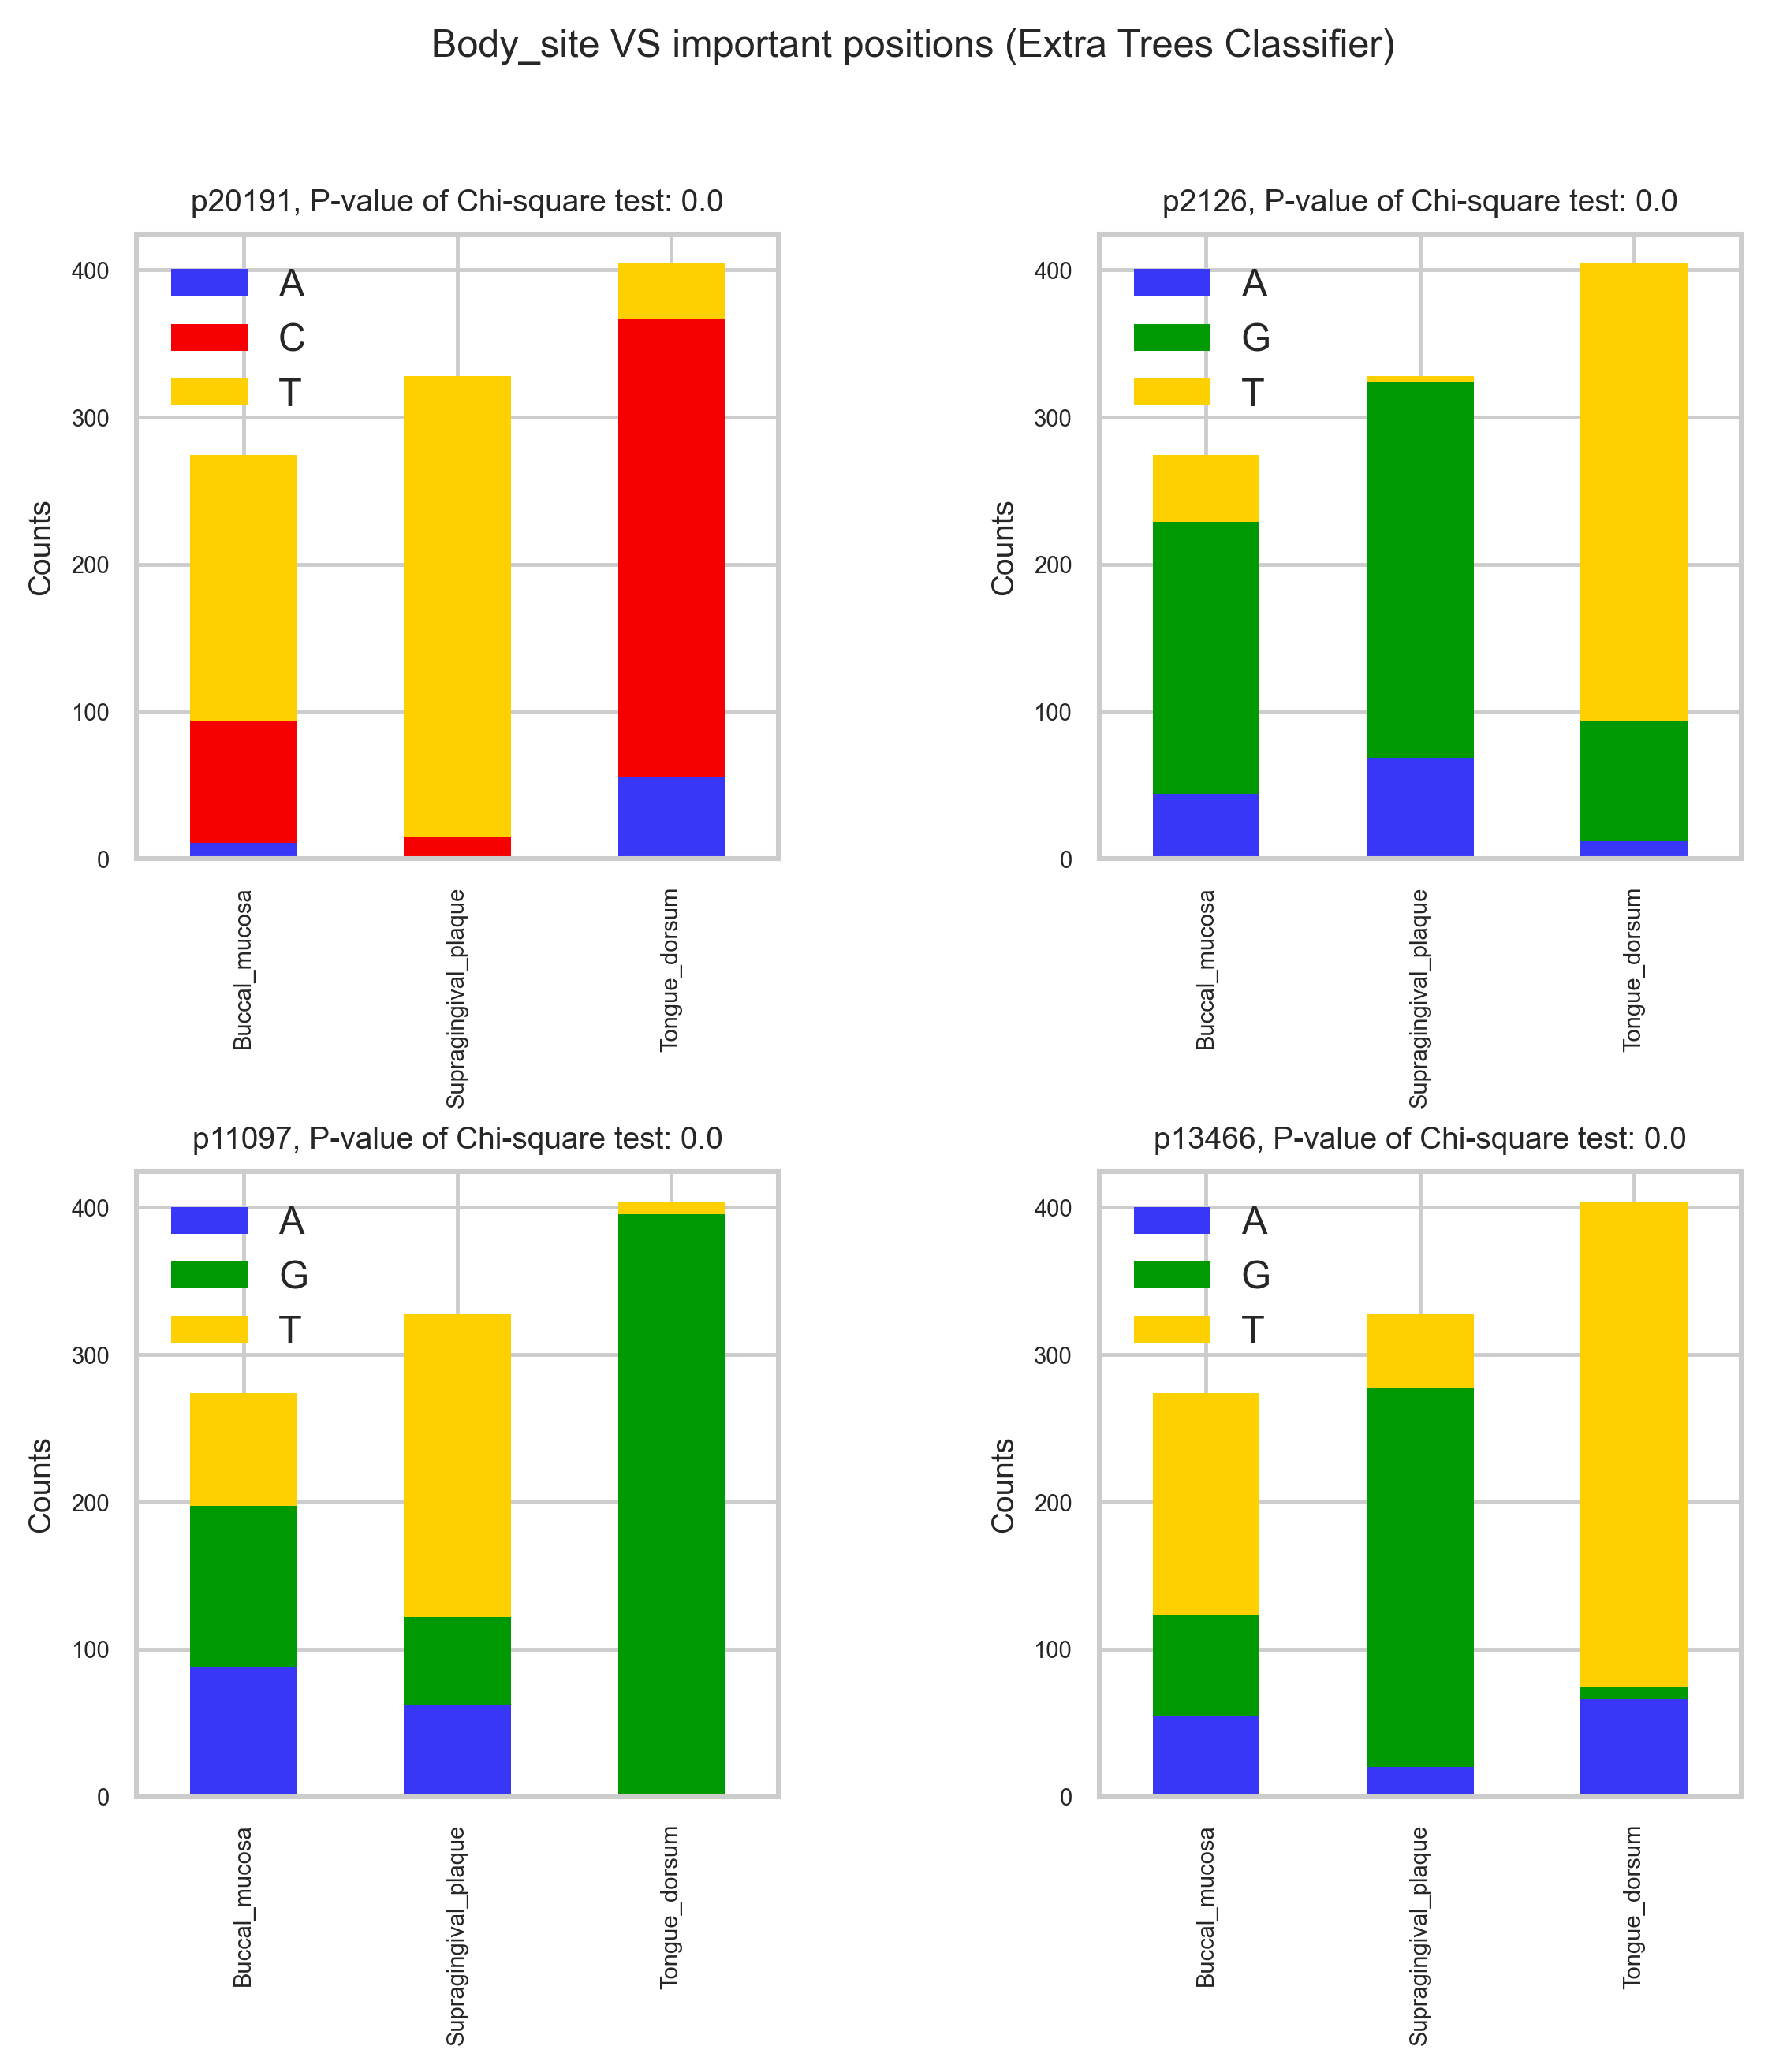

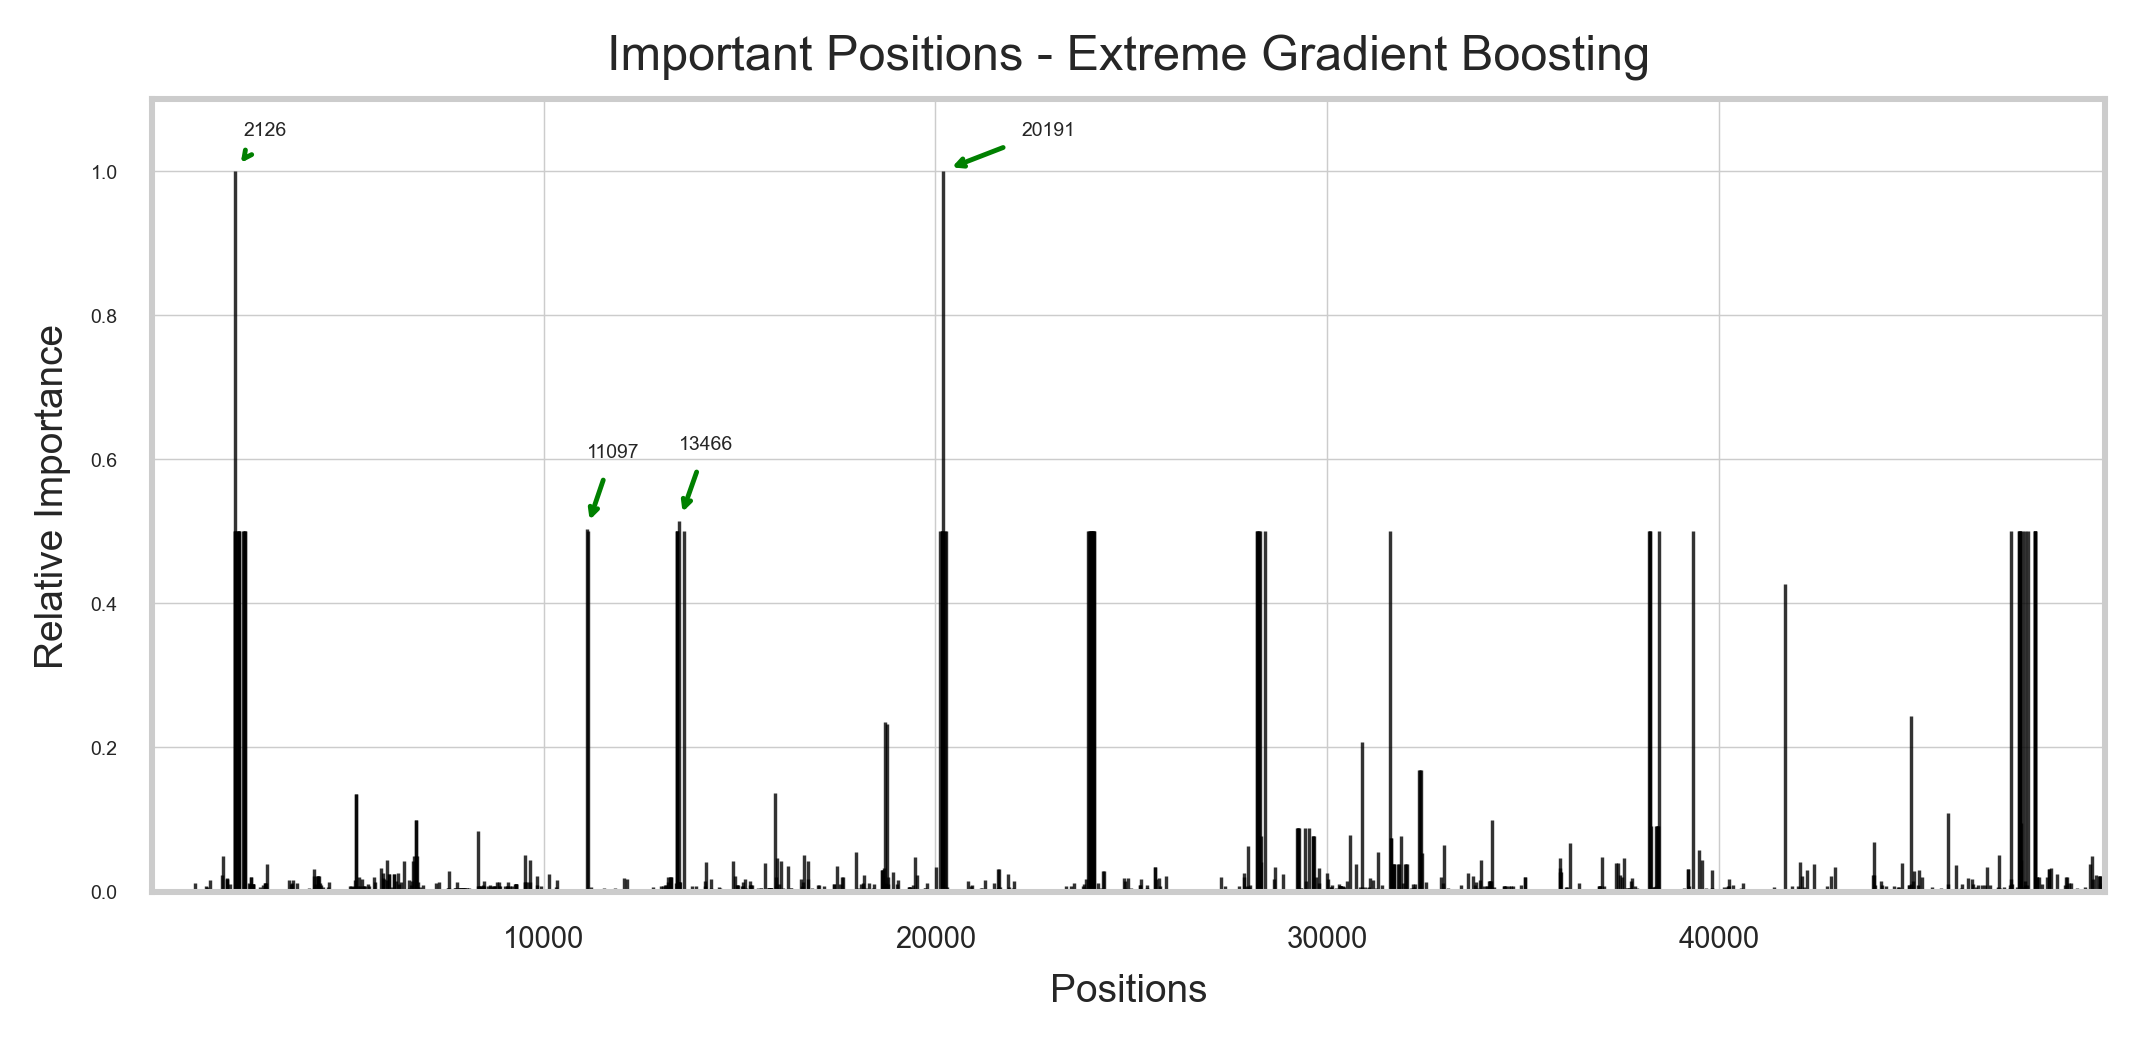

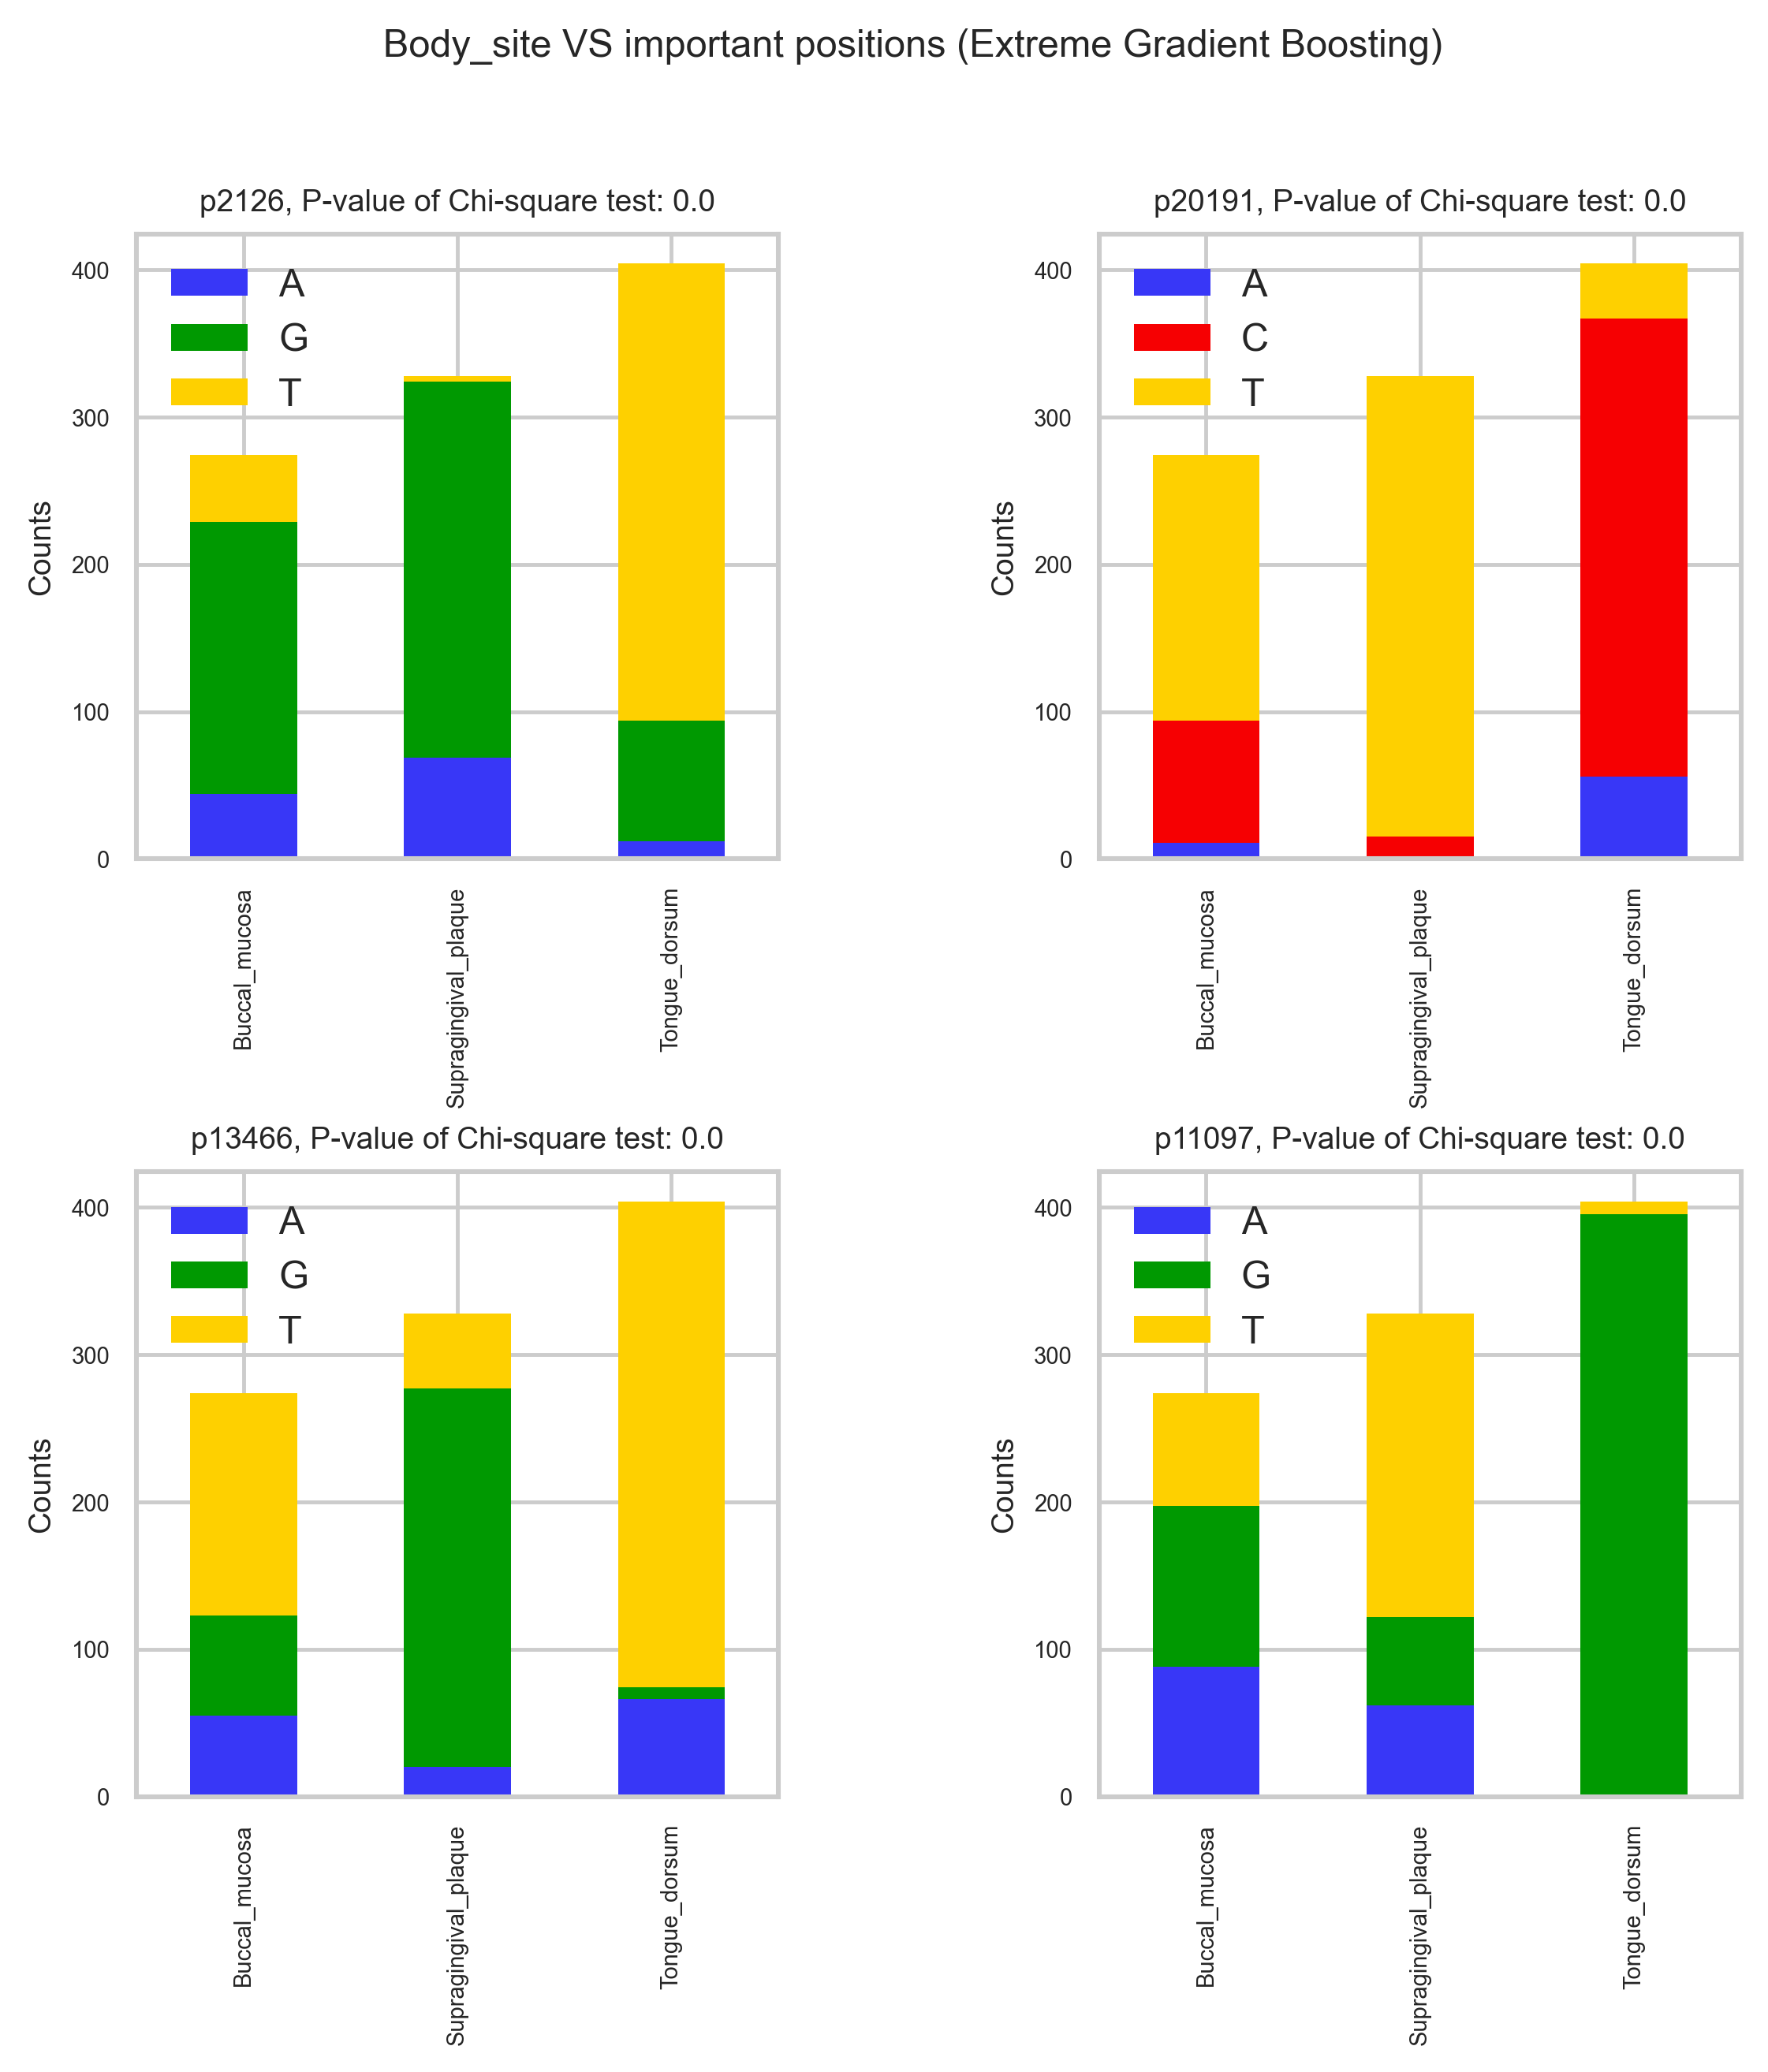

In [24]:
for i in range(models_to_select):
    # calculate the featre importances
    imp = ml.fimp_single(trained_model=top_models[i], model_name=model_names[i],
                         train_cols=train_cols, grouped_features=dc,
                         n_positions=positions, report_dir=report_dir)
    # visualize the lollipop plot for features based on each model
    viz.dp_plot(dat = imp, model_name= model_names[i],imp_col='standard_value', report_dir=report_dir)
    
    # visualize the boxplots for features based on each model
    viz.plot_imp_model(dat=df, trained_model=top_models[i],
                       model_name=model_names[i],
                       train_cols=train_cols, grouped_features=dc,
                       meta_var=mt, n_positions=positions,
                       model_type=anaType, report_dir=report_dir)

/Users/mbagh/Documents/RahLab/deepBreaks_data/hmp/s__Haemophilus_parainfluenzae_Body_site_2022-10-18_13-02-50/mean_350.png


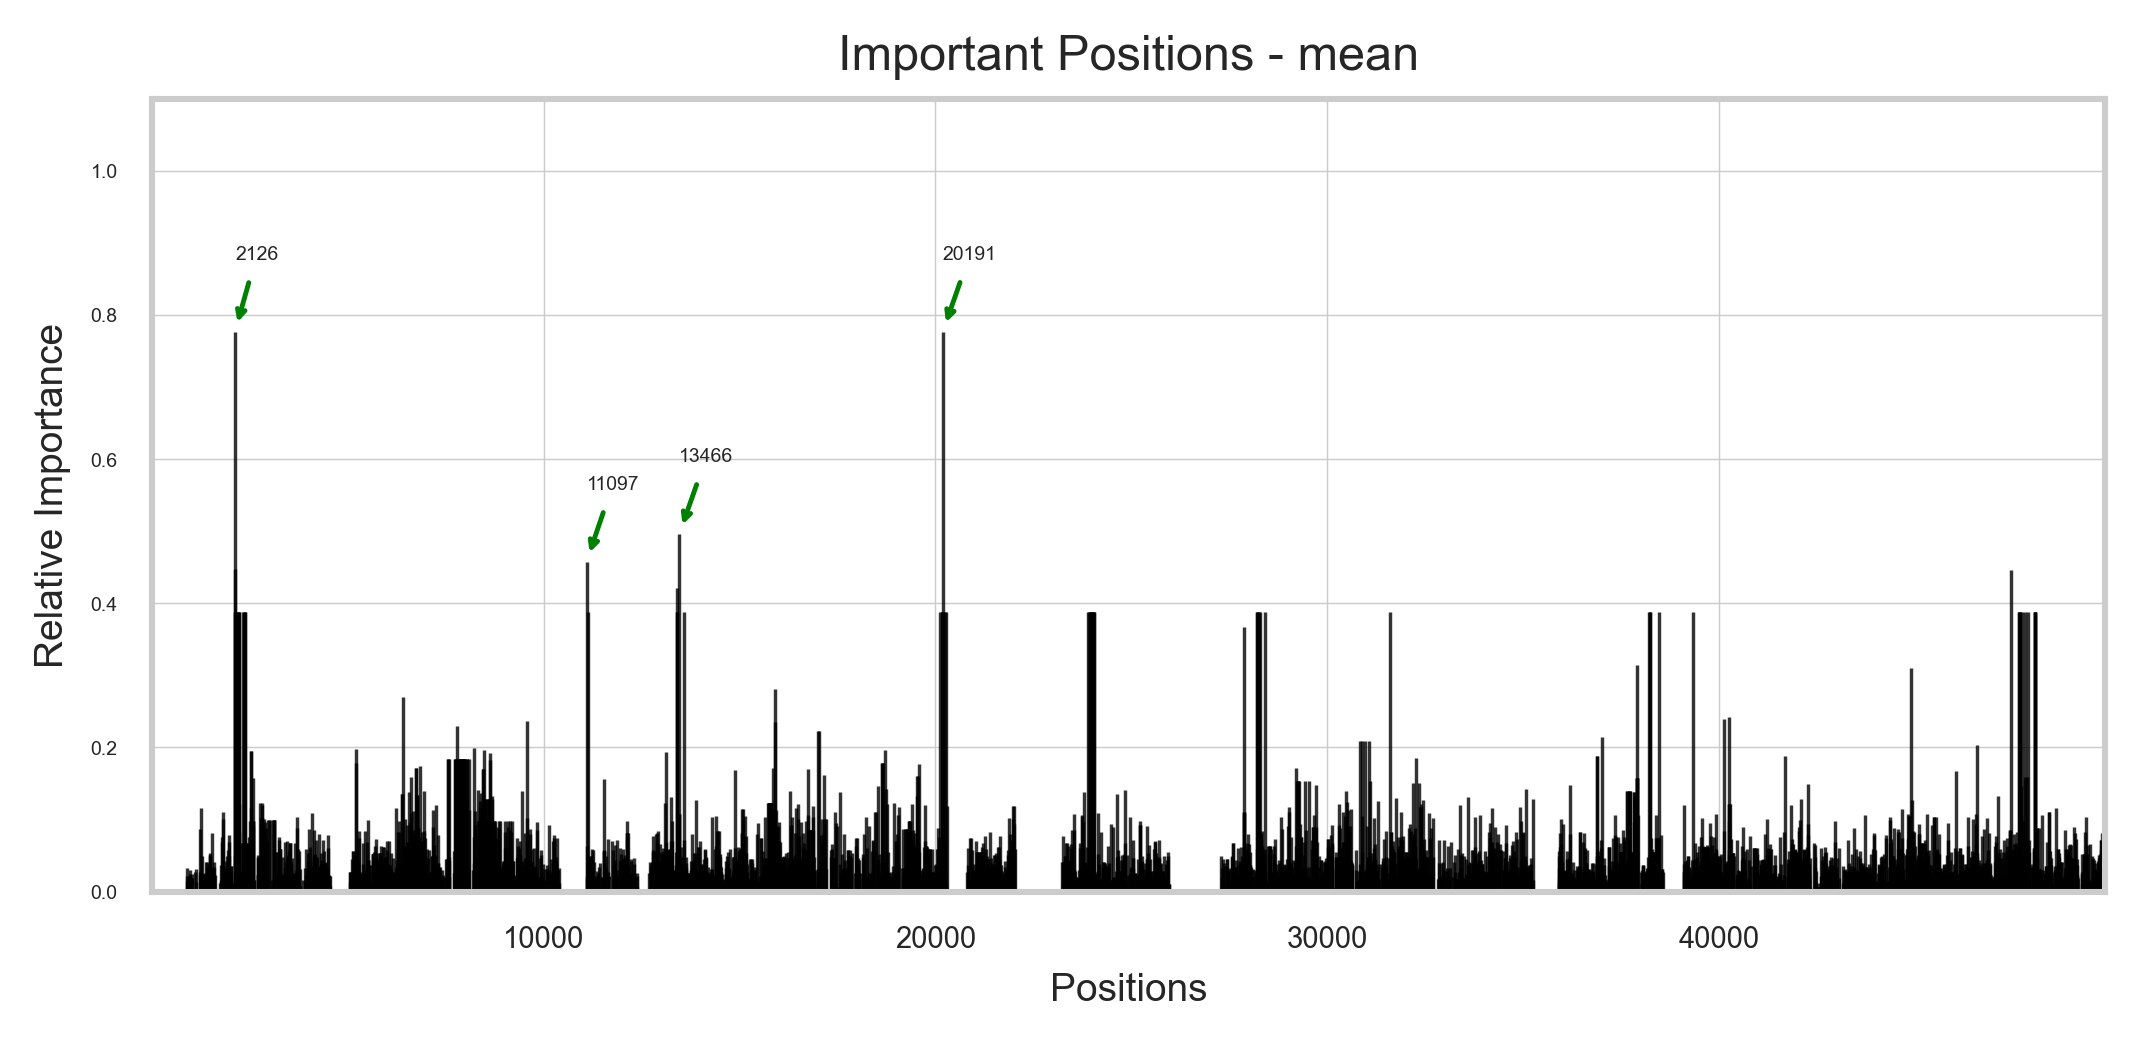

/Users/mbagh/opt/anaconda3/envs/deepBreaks_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/mbagh/opt/anaconda3/envs/deepBreaks_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/mbagh/opt/anaconda3/envs/deepBreaks_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/mbagh/opt/anaconda3/envs/deepBreaks_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, 

In [25]:
# merging the results for all the top models
mean_imp = ml.fimp_top_models(trained_models=top_models, model_names=model_names, 
                              train_cols=train_cols,grouped_features=dc,
                              n_positions=positions,report_dir=report_dir)

# lollipop plot for the merged results
viz.dp_plot(dat=mean_imp,
            model_name= 'mean',
            imp_col='mean_imp', 
            report_dir=report_dir)

**Running the next cell will produce individual plots for all of the positions in you sequence.**

In [ ]:
# visualizing top positions 

# viz.plot_imp_all(trained_models=top_models, dat=df, train_cols=train_cols,
#                  grouped_features=dc, meta_var=mt, model_type=anaType,
#                  n_positions=positions, report_dir=report_dir)